In [1]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import netCDF4
import cftime
import seaborn
import cmocean
import matplotlib.gridspec
import scipy.interpolate

import glob
import pandas

import astropy.convolution

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

In [2]:
cartopy.__version__

'0.16.0'

# 30day runs

import cam 400 data

In [3]:
cont_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/ens_mean_cesm_files/'
cont_filename = 'B_1850_CAM5.30days.cam0400.clm0400.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
cont_cam_ds = xarray.open_dataset(cont_fileroot+cont_filename, decode_times=False)

In [4]:
cont_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/ens_mean_cesm_files/'
cont_filename = 'B_1850_CAM5.30days.cam0400.clm0400.ens.clm2.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
cont_clm_ds = xarray.open_dataset(cont_fileroot+cont_filename, decode_times=False)

In [5]:
topo_filename = 'USGS-gtopo30_1.9x2.5_remap_c050602.nc'
topo_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm0400.ens_10members/'
topo_ds = xarray.open_dataset(topo_fileroot+topo_filename, decode_times=False)

calculate latitude information

In [6]:
lat_lo_open = -35.
lat_hi_open = 35.
lat_lo = -10.
lat_hi = 10.
lon_lo = 270.
lon_hi = 330.

In [7]:
lat = cont_cam_ds['lat'].sel(lat=slice(lat_lo_open,lat_hi_open)).values
lon = cont_cam_ds['lon'].sel(lon=slice(lon_lo,lon_hi)).values

lat_indices = (lat>=lat_lo)&(lat<=lat_hi)
lat_indices_open = (lat>=lat_lo_open)&(lat<=lat_hi_open)
lon_indices = (lon>=lon_lo)&(lon<=lon_hi)

lat_subset = lat[lat_indices]
lon_subset = lon[lon_indices]

lat_subset_open = lat[lat_indices_open]

In [8]:
lat_subset_open = lat[lat_indices_open]

get land fraction info

In [9]:
LANDFRAC = cont_cam_ds['LANDFRAC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values[0,:,:]

get 400 fields for cam

In [10]:
PRECC_400_30d = cont_cam_ds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_30d = cont_cam_ds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

In [11]:
SOILLIQ_400_30d = cont_clm_ds['SOILLIQ'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

import cam 1000 data

In [12]:
phys_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm1000.ens_10members/ens_mean_cesm_files/'
phys_filename = 'B_1850_CAM5.30days.cam0400.clm1000.ens.cam.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
phys_cam_ds = xarray.open_dataset(phys_fileroot+phys_filename, decode_times=False)

In [13]:
phys_fileroot = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.30days.cam0400.clm1000.ens_10members/ens_mean_cesm_files/'
phys_filename = 'B_1850_CAM5.30days.cam0400.clm1000.ens.clm2.h0.0011-03-20-0000_0011-04-20-0000_ens_mean.nc'
phys_clm_ds = xarray.open_dataset(phys_fileroot+phys_filename, decode_times=False)

get 1000 fields for cam

In [14]:
PRECC_1000_30d = phys_cam_ds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_30d = phys_cam_ds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

In [15]:
SOILLIQ_1000_30d = phys_clm_ds['SOILLIQ'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values

convert time information

In [16]:
time_400 = cont_cam_ds['time']
time_converted = netCDF4.num2date(time_400.values, time_400.units, time_400.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))

specify timing

In [17]:
skip_time = 24
#end_time = 745

calculate PRECT diffs

In [18]:
PRECT_400_30d = PRECC_400_30d+PRECL_400_30d
PRECT_1000_30d = PRECC_1000_30d+PRECL_1000_30d

In [19]:
PRECT_1000_timemean_10day = numpy.mean(PRECT_1000_30d[skip_time:240,:,:], axis=0)
PRECT_1000_timemean_10day_landmask = numpy.copy(PRECT_1000_timemean_10day)
PRECT_1000_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_10day = numpy.nanmean(PRECT_400_30d[skip_time:240,:,:], axis=0)
PRECT_400_timemean_10day_landmask = numpy.copy(PRECT_400_timemean_10day)
PRECT_400_timemean_10day_landmask[LANDFRAC==0] = numpy.nan

In [20]:
SOILLIQ_1000_timemean_10day = numpy.nanmean(SOILLIQ_1000_30d[skip_time:240,:,:,:], axis=0)
SOILLIQ_400_timemean_10day = numpy.nanmean(SOILLIQ_400_30d[skip_time:240,:,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [21]:
PRECT_1000_timemean_30day = numpy.mean(PRECT_1000_30d[skip_time:,:,:], axis=0)
PRECT_1000_timemean_30day_landmask = numpy.copy(PRECT_1000_timemean_30day)
PRECT_1000_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

PRECT_400_timemean_30day = numpy.nanmean(PRECT_400_30d[skip_time:,:,:], axis=0)
PRECT_400_timemean_30day_landmask = numpy.copy(PRECT_400_timemean_30day)
PRECT_400_timemean_30day_landmask[LANDFRAC==0] = numpy.nan

In [22]:
SOILLIQ_1000_timemean_30day = numpy.nanmean(SOILLIQ_1000_30d[skip_time:,:,:,:], axis=0)
SOILLIQ_400_timemean_30day = numpy.nanmean(SOILLIQ_400_30d[skip_time:,:,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


get topography info

In [23]:
topo_data = topo_ds['PHIS'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values/9.80665

In [24]:
topo_data_landmask = numpy.copy(topo_data)
topo_data_landmask[LANDFRAC==0] = numpy.nan
topo_data_latmean = numpy.nanmean(topo_data_landmask, axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# 10year simulations

400 clm runs

In [25]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
cont_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False)

In [26]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
cont_clm_ds_list = [xarray.open_dataset(file, decode_times=False).sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)) \
                    for file in file_list]

In [27]:
PRECC_400_10y = cont_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_10y = cont_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_400_10y = PRECC_400_10y+PRECL_400_10y

In [28]:
SOILLIQ_400_list = [f['SOILLIQ'].values for f in cont_clm_ds_list]
#SOILWATER_400_list = [f['SOILWATER_10CM'].values for f in cont_clm_ds_list]

1000 clm runs

In [29]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
phys_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc')#, decode_times=False)

In [30]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
phys_clm_ds_list = [xarray.open_dataset(file, decode_times=False).sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)) \
                    for file in file_list]

In [31]:
PRECC_1000_10y = phys_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_10y = phys_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_1000_10y = PRECC_1000_10y+PRECL_1000_10y

In [32]:
SOILLIQ_1000_list = [f['SOILLIQ'].values for f in phys_clm_ds_list]
#SOILWATER_1000_list = [f['SOILWATER_10CM'].values for f in phys_clm_ds_list]

take time averages

In [33]:
PRECT_400_timemean_10year = numpy.mean(PRECT_400_10y, axis=0)
PRECT_1000_timemean_10year = numpy.mean(PRECT_1000_10y, axis=0)

In [34]:
PRECT_400_timemean_10year_landmask = numpy.copy(PRECT_400_timemean_10year)
PRECT_1000_timemean_10year_landmask = numpy.copy(PRECT_1000_timemean_10year)

PRECT_400_timemean_10year_landmask[LANDFRAC==0] = numpy.nan
PRECT_1000_timemean_10year_landmask[LANDFRAC==0] = numpy.nan

In [35]:
SOILLIQ_400_10y = numpy.concatenate(SOILLIQ_400_list, axis=0)
SOILLIQ_1000_10y = numpy.concatenate(SOILLIQ_1000_list, axis=0)

In [36]:
SOILLIQ_400_timemean_10year = numpy.mean(SOILLIQ_400_10y, axis=0)
SOILLIQ_1000_timemean_10year = numpy.mean(SOILLIQ_1000_10y, axis=0)

In [37]:
cesm_soil_levels = phys_clm_ds_list[0]['levgrnd'].values*100. # units: meters, change to centimeters

# calculate all differences

In [38]:
PRECT_diffs_10day = PRECT_1000_timemean_10day_landmask-PRECT_400_timemean_10day_landmask
PRECT_diffs_30day = PRECT_1000_timemean_30day_landmask-PRECT_400_timemean_30day_landmask
PRECT_diffs_10year = PRECT_1000_timemean_10year_landmask-PRECT_400_timemean_10year_landmask

In [39]:
SOILLIQ_diffs_10day = SOILLIQ_1000_timemean_10day-SOILLIQ_400_timemean_10day
SOILLIQ_diffs_30day = SOILLIQ_1000_timemean_30day-SOILLIQ_400_timemean_30day
SOILLIQ_diffs_10year = SOILLIQ_1000_timemean_10year-SOILLIQ_400_timemean_10year

# wrf 50km runs

## 400 data

In [40]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [41]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [42]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [43]:
soilh2o_400 = cont_mfds['SH2O'].values
wrf_soil_layers_ctr = cont_mfds['ZS'].isel(Time=0).values

In [44]:
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [45]:
xlat_indices = (xlat>=-10)&(xlat<=10.)

In [46]:
hgt_50km = cont_mfds['HGT'].sel(Time=0).values

In [47]:
hgt_50km_landmask = numpy.copy(hgt_50km)
hgt_50km_landmask[landmask==0] = numpy.nan

hgt_50km_landmask_lat_subset = hgt_50km_landmask[xlat_indices[:,0],:]
hgt_50km_latmean = numpy.nanmean(hgt_50km_landmask_lat_subset, axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


## 1000 data

In [48]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [49]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [50]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

In [51]:
soilh2o_1000 = phys_mfds['SH2O'].values

## calculate WRF differences

In [52]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

raintot_400_diff = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_400_diff[:-1,:,:] = numpy.diff(raintot_400, axis=0)#*(24./3) # convert to mm/day

raintot_1000_diff = numpy.zeros((raintot_1000.shape))*numpy.nan
raintot_1000_diff[:-1,:,:] = numpy.diff(raintot_1000, axis=0)#*(24./3) # convert to mm/day

# monthly mean
raintot_diffs_time_mean = numpy.nanmean(raintot_1000_diff[skip_time:,:,:] - raintot_400_diff[skip_time:,:,:], axis=0)
raintot_diffs_time_mean_landmask = numpy.copy(raintot_diffs_time_mean)
raintot_diffs_time_mean_landmask[landmask==0] = numpy.nan

raintot_400_time_mean = numpy.nanmean(raintot_400_diff[skip_time:,:,:], axis=0)
raintot_400_time_mean_landmask = numpy.copy(raintot_400_time_mean)
raintot_400_time_mean_landmask[landmask==0] = numpy.nan

In [53]:
day1_start_hour = 10 #6am = 10:00 because of the time offset
day1_end_hour = 24 #8pm = 24:00 because of time offset
raintot_diffs_time_mean_day1 = numpy.nanmean(raintot_1000_diff[day1_start_hour:day1_end_hour+1,:,:] - raintot_400_diff[day1_start_hour:day1_end_hour+1,:,:], axis=0)
raintot_diffs_time_mean_day1_landmask = numpy.copy(raintot_diffs_time_mean_day1)
raintot_diffs_time_mean_day1_landmask[landmask==0] = numpy.nan

In [54]:
soilh2o_diffs = soilh2o_1000-soilh2o_400

soilh2o_diffs_landmask = numpy.copy(soilh2o_diffs)
soilh2o_diffs_landmask[:,:,landmask==0] = numpy.nan

In [55]:
soilh2o_diffs_time_mean = numpy.nanmean(soilh2o_diffs_landmask[skip_time:,:,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# import WRF 2km days 2-10

In [56]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/001/'
cont_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [57]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/001/'
phys_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [58]:
raintot_400_2km = cont_mfds_2km['RAINNC']
raintot_1000_2km = phys_mfds_2km['RAINNC']

In [59]:
raintot_400_2km_diffs = raintot_400_2km.diff(dim='Time').values
raintot_1000_2km_diffs = raintot_1000_2km.diff(dim='Time').values

In [60]:
soilh2o_400_2km = cont_mfds_2km['SH2O'].values
soilh2o_1000_2km = phys_mfds_2km['SH2O'].values

In [61]:
raintot_400_2km_time_mean = numpy.nanmean(raintot_400_2km_diffs[skip_time:,:,:], axis=0)
raintot_1000_2km_time_mean = numpy.nanmean(raintot_1000_2km_diffs[skip_time:,:,:], axis=0)

raintot_diffs_2km_time_mean = raintot_1000_2km_time_mean-raintot_400_2km_time_mean

In [62]:
landmask_2km = cont_mfds_2km['LANDMASK'].values[0,:,:]

In [63]:
raintot_diffs_2km_time_mean_landmask = numpy.copy(raintot_diffs_2km_time_mean)
raintot_diffs_2km_time_mean_landmask[landmask_2km==0] = numpy.nan

In [64]:
soilh2o_diffs_2km = soilh2o_1000_2km-soilh2o_400_2km

soilh2o_diffs_2km_landmask = numpy.copy(soilh2o_diffs_2km)
soilh2o_diffs_2km_landmask[:,:,landmask_2km==0] = numpy.nan

In [65]:
soilh2o_diffs_2km_time_mean = numpy.nanmean(soilh2o_diffs_2km_landmask[skip_time:,:,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [66]:
xlat_2km = cont_mfds_2km['XLAT'].values[0,:,:]
xlong_2km = cont_mfds_2km['XLONG'].values[0,:,:]

In [67]:
hgt_2km = cont_mfds_2km['HGT'].sel(Time=0).values

In [68]:
hgt_2km_landmask = numpy.copy(hgt_2km)
hgt_2km_landmask[landmask_2km==0] = numpy.nan
hgt_2km_latmean = numpy.nanmean(hgt_2km_landmask, axis=0)

# create plots

## calculate lat means

In [69]:
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)

In [70]:
raintot_diffs_time_mean_landmask.shape

(179, 289)

In [71]:
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)
PRECT_diffs_10day_latmean = numpy.nanmean(PRECT_diffs_10day[lat_indices,:], axis=0)
PRECT_diffs_30day_latmean = numpy.nanmean(PRECT_diffs_30day[lat_indices,:], axis=0)
PRECT_diffs_10year_latmean = numpy.nanmean(PRECT_diffs_10year[lat_indices,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


calculate stdevs

In [72]:
raintot_diffs_latstd = numpy.nanstd(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_day1_latstd = numpy.nanstd(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_2km_latstd = numpy.nanstd(raintot_diffs_2km_time_mean, axis=0, ddof=1)
PRECT_diffs_10day_latstd = numpy.nanstd(PRECT_diffs_10day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_30day_latstd = numpy.nanstd(PRECT_diffs_30day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_10year_latstd = numpy.nanstd(PRECT_diffs_10year[lat_indices,:], axis=0, ddof=1)



/export/home/blangenb/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


calculate stderr

In [73]:
raintot_diffs_latstderr = raintot_diffs_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_day1_latstderr = raintot_diffs_day1_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_2km_latstderr = raintot_diffs_2km_latstd/numpy.sqrt(xlat_2km[:,0].size)
PRECT_diffs_10day_latstderr = PRECT_diffs_10day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_30day_latstderr = PRECT_diffs_30day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_10year_latstderr = PRECT_diffs_10year_latstd/numpy.sqrt(lat_subset.size)

In [74]:
raintot_diffs_latmean_smooth = pandas.Series(raintot_diffs_latmean).rolling(window=3, center=True, min_periods=0).mean()
raintot_diffs_latmean_smooth_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=3, center=True, min_periods=0).mean()

raintot_diffs_2km_latmean_smooth = pandas.Series(raintot_diffs_2km_latmean).rolling(window=75, center=True, min_periods=0).mean()
PRECT_diffs_10day_latmean_smooth = pandas.Series(PRECT_diffs_10day_latmean).rolling(window=3, center=True, min_periods=0).mean()



In [75]:
raintot_diffs_latstd_smooth = pandas.Series(raintot_diffs_latstd).rolling(window=3, center=True, min_periods=0).std(ddof=1)
raintot_diffs_2km_latstd_smooth = pandas.Series(raintot_diffs_2km_latstd).rolling(window=75, center=True, min_periods=0).std(ddof=1)



## with error bars

[Text(270,0,'280$\\degree$E'),
 Text(280,0,''),
 Text(290,0,'300$\\degree$E'),
 Text(300,0,''),
 Text(310,0,'320$\\degree$E')]

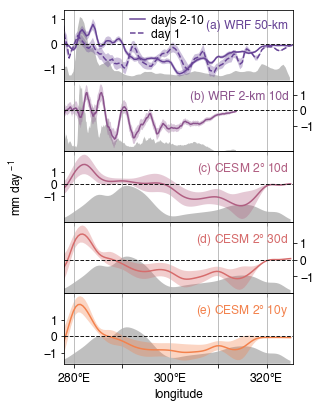

In [76]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 12

fig = mp.figure(figsize=(4.25,5.5))

ymax = 1920.6472595214843
##################################################
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth*24., \
         color=colors[0],\
         label='days 2-10')

ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth_day1*24., \
         color=colors[0],\
         label='day 1', ls='--')

ax1topo = ax1.twinx()
ax1topo.fill_between(xlong[0,:]+360., \
                     numpy.zeros(hgt_50km_latmean.size), \
                     hgt_50km_latmean, \
                     facecolor='0', alpha=0.25)
y0,y1 = ax1topo.get_ylim()
ax1topo.set_ylim(0,ymax)
ax1topo.axis('off')

ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth-1.96*raintot_diffs_latstderr)*24.,\
                (raintot_diffs_latmean_smooth+1.96*raintot_diffs_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)


ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth_day1-1.96*raintot_diffs_day1_latstderr)*24.,\
                (raintot_diffs_latmean_smooth_day1+1.96*raintot_diffs_day1_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)

##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')

ax2topo = ax2.twinx()
ax2topo.fill_between(xlong_2km[0,:]+360., \
                     numpy.zeros(hgt_2km_latmean.size), \
                     hgt_2km_latmean, \
                     facecolor='0', alpha=0.25)
ax2topo.set_ylim(0,ymax)
ax2topo.axis('off')

yvals = raintot_diffs_2km_latstderr*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax2.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp, \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')

yvals = PRECT_diffs_10day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax3.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[2], alpha=0.333)

ax3topo = ax3.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax3topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax3topo.set_ylim(0,ymax)
ax3topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp, \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax4.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[3], alpha=0.333)

ax4topo = ax4.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax4topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax4topo.set_ylim(0,ymax)
ax4topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp, \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax5.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[4], alpha=0.333)

ax5topo = ax5.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax5topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax5topo.set_ylim(0,ymax)
ax5topo.axis('off')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['(a) WRF 50-km',\
              '(b) WRF 2-km 10d', \
              '(c) CESM 2$\degree$ 10d', \
              '(d) CESM 2$\degree$ 30d', \
              '(e) CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.275,0.98), \
          bbox_transform=ax1.transAxes, loc='upper left', borderaxespad=0, ncol=1, labelspacing=0.19, \
          fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
          handletextpad=0.5, handlelength=1.2)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

#fig.savefig('figures/manuscript_fig4_precip_change_latmean_plots_with_error_bars.png', dpi=600, bbox_inches='tight', transparent=True)

# Plot WRF 50km and 2km map plus meridional mean precip decrease below

In [77]:
xlat_indices = (xlat[:,0]>=-10.) & (xlat[:,0]<=10.)
xlong_indices = (xlong[0,:]>=280-360.)&(xlong[0,:]<=320-260.)

In [78]:
raintot_diffs_landmask = raintot_1000_diff-raintot_400_diff
raintot_diffs_landmask[:,landmask==0] = numpy.nan
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_landmask[:,xlat_indices,:], axis=1)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_latmean[:24,:], axis=0)
raintot_diffs_latmean_days2to10 = numpy.nanmean(raintot_diffs_latmean[24:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [80]:
raintot_diffs_latmean_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=3, \
                                                                               center=True, \
                                                                               min_periods=1).mean()

raintot_diffs_latmean_days2to10 = pandas.Series(raintot_diffs_latmean_days2to10).rolling(window=3, \
                                                                               center=True, \
                                                                               min_periods=1).mean()

raintot_diffs_latmean_std_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=10, \
                                                                                   center=True, \
                                                                                   min_periods=1).std(ddof=1)

raintot_diffs_latmean_std_days2to10 = pandas.Series(raintot_diffs_latmean_days2to10).rolling(window=10, \
                                                                                   center=True, \
                                                                                   min_periods=1).std(ddof=1)

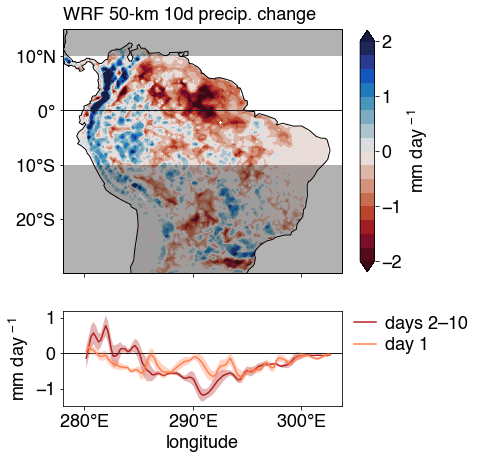

In [81]:
fontsize=18

fig = mp.figure(figsize=(5,6.5))
gs = matplotlib.gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[3, 1])

map_proj = cartopy.crs.PlateCarree()
levels1 = numpy.arange(-2,2.1,0.25)

ax1 = fig.add_subplot(gs[0], projection=map_proj)
contour1 = ax1.contourf(xlong[0,:], xlat[:,0], \
                        raintot_diffs_time_mean_landmask*24., \
                        levels=levels1, cmap=cmocean.cm.balance_r, extend='both')
ax1.set_extent([276,327.5,-30,15], crs=map_proj)
ax1.coastlines()
ax1.set_xticks([280-360.,300-360.,320-360.])
ax1.set_xticklabels(['','',''])
ax1.set_yticks([-20,-10,0,10])
ax1.set_yticklabels(['$20\degree$S','$10\degree$S', '$0\degree$', '$10\degree$N'])
ax1.tick_params(labelsize=fontsize)
ax1.axhline(0, c='0.1', lw=1)

ax1.fill_between(numpy.linspace(276,327.5,2), y1=-10, y2=-40, \
                 alpha=0.333, edgecolor='None', \
                 facecolor='0.1', transform=map_proj)
ax1.fill_between(numpy.linspace(276,327.5,2), y1=10, y2=40, \
                 alpha=0.333, edgecolor='None', \
                 facecolor='0.1', transform=map_proj)

ax1.text(s='WRF 50-km 10d precip. change', x=0, y=1.02, \
         transform=ax1.transAxes, \
         fontsize=fontsize, ha='left', va='bottom')

ax2 = fig.add_subplot(gs[1])
ax2.set_xlim(276,327.5)
ax2.tick_params(labelsize=fontsize)
ax2.set_xticks([280,300,320])
ax2.set_xticklabels(['$280\degree$E','$290\degree$E','$300\degree$E','$310\degree$E'])
ax2.set_xlabel('longitude', fontsize=fontsize)
ax2.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)
ax2.axhline(0, c='0.1', lw=1)

ax2.plot(xlong[0,xlong_indices]+360.,\
        raintot_diffs_latmean_days2to10[xlong_indices]*24., \
        c='firebrick', label='days 2–10')

ax2.fill_between(xlong[0,xlong_indices]+360., \
                (raintot_diffs_latmean_days2to10[xlong_indices]-raintot_diffs_latmean_std_days2to10[xlong_indices])*24.,\
                (raintot_diffs_latmean_days2to10[xlong_indices]+raintot_diffs_latmean_std_days2to10[xlong_indices])*24.,\
                facecolor='firebrick', alpha=0.333)

ax2.plot(xlong[0,xlong_indices]+360.,\
        raintot_diffs_latmean_day1[xlong_indices]*24., \
        c='coral', label='day 1', zorder=5)

ax2.fill_between(xlong[0,xlong_indices]+360., \
                (raintot_diffs_latmean_day1[xlong_indices]-raintot_diffs_latmean_std_day1[xlong_indices])*24.,\
                (raintot_diffs_latmean_day1[xlong_indices]+raintot_diffs_latmean_std_day1[xlong_indices])*24.,\
                facecolor='coral', alpha=0.333, zorder=5)

ax2.set_ylim(-1.4835328969152064, 1.1870771995510045)

fig.tight_layout()
h, l=ax2.get_legend_handles_labels()
ax2.legend(h, l, fontsize=fontsize, scatterpoints=1, bbox_to_anchor=(1.025,1.), \
            bbox_transform=ax2.transAxes, loc='upper left', borderaxespad=0, labelspacing=0.25, \
            fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
            handletextpad=0.5, markerscale=1, handlelength=1.25)

scale = .85
ax1pos = ax1.get_position()
cbar_ax = fig.add_axes([ax1pos.x1+0.05, ax1pos.y0+.5*(1-scale)*ax1pos.height, 0.04, ax1pos.height*scale])
cbar = mp.colorbar(contour1, cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks([-2,-1,0,1,2])

#fig.savefig('../figures/WRF_map_and_meridional_means_2lines.png', dpi=600, bbox_inches='tight', transparent=True)

# maps of change

custom color map stuff

In [82]:
turbid = cmocean.cm.turbid_r
deep = cmocean.cm.deep
turbid_colors = turbid(numpy.linspace(0,1,128))
deep_colors = deep(numpy.linspace(0,1,128))
turbid_deep_colors = numpy.vstack((turbid_colors,deep_colors))
turbid_deep_colors
turbid_deep_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('turbid_deep', turbid_deep_colors)

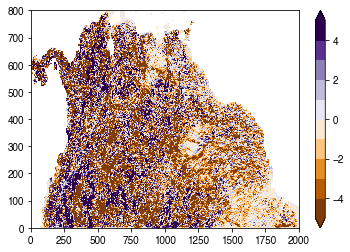

In [83]:
levels_2km = numpy.arange(-5,5.1,1)
cmap_2km = matplotlib.cm.PuOr #turbid_deep_cmap
norm = matplotlib.colors.BoundaryNorm(levels_2km, cmap_2km.N)
mp.pcolormesh(raintot_diffs_2km_time_mean_landmask*24.,\
              cmap=cmap_2km, norm=norm)
mp.colorbar(extend='both')

In [84]:
raintot_diffs_2km_time_mean_landmask_interpolated = \
scipy.interpolate.griddata((xlong_2km.flatten(), xlat_2km.flatten()), \
                           raintot_diffs_2km_time_mean_landmask.flatten(), \
                           (xlong.flatten(),xlat.flatten()) )

In [ ]:
raintot_diffs_2km_time_mean_landmask_interpolated = \
scipy.interpolate.griddata((xlong_2km.flatten(), xlat_2km.flatten()), \
                           raintot_diffs_2km_time_mean_landmask.flatten(), \
                           (xlong.flatten(),xlat.flatten()) )

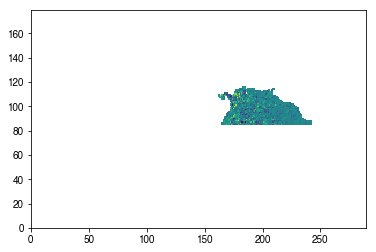

In [85]:
mp.pcolormesh(raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape)))

In [86]:
kernel_std = .55
#kernel = astropy.convolution.Gaussian2DKernel(x_stddev=kernel_std, y_stddev=kernel_std)
kernel = astropy.convolution.Gaussian2DKernel(x_stddev=kernel_std, y_stddev=kernel_std)
field = raintot_diffs_2km_time_mean_landmask_interpolated.reshape(xlong.shape)
raintot_diffs_convolved = astropy.convolution.convolve(field, kernel)
raintot_diffs_convolved[landmask==0]=numpy.nan

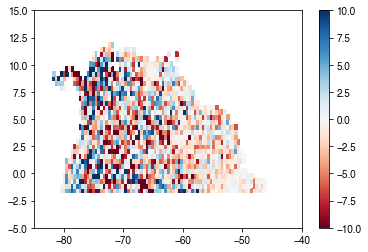

In [87]:
clevels = numpy.arange(-3.25,3.251,0.25)
mp.pcolormesh(xlong, xlat, raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape))*24., \
            vmin=-10,vmax=10,\
            cmap='RdBu')
mp.xlim(-85,-40)
mp.ylim(-5,15)
mp.colorbar()

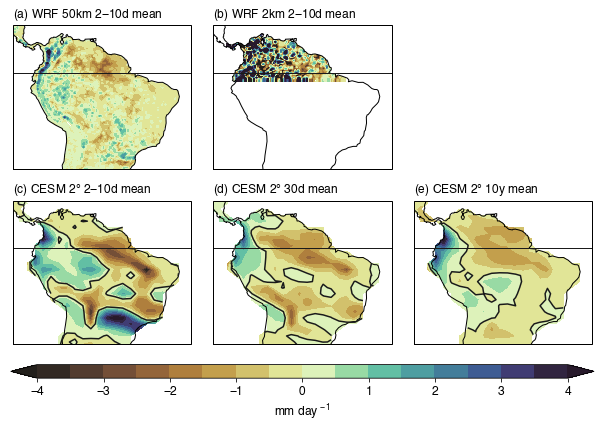

In [88]:
fontsize=12

fig = mp.figure(figsize=(8.5,4.75))

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(231, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(232, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(234, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(235, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(236, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-4,4.1,0.5)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        raintot_diffs_convolved*24., \
                        levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax3.contour(lon_subset, lat_subset_open, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax4.contour(lon_subset, lat_subset_open, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax5.contour(lon_subset, lat_subset_open, PRECT_diffs_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(a) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(b) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='(c) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(d) CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(e) CESM 2$\degree$ 10y mean', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

fig.tight_layout(h_pad=3)

axlpos = ax3.get_position()
axrpos = ax5.get_position()

cbar_ax = fig.add_axes([axlpos.x0,axlpos.y0-0.1,axrpos.x1-axlpos.x0,0.04])
cbar = fig.colorbar(contour4, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

# ax2kmpos = ax2.get_position()
# cbar_ax2 = fig.add_axes([ax2kmpos.x1+0.03,ax2kmpos.y0,0.02,ax2kmpos.height])
# cbar2 = fig.colorbar(contour2, cax=cbar_ax2, orientation='vertical', extend='both')
# cbar_ax2.tick_params(labelsize=fontsize)
# cbar2.set_label('mm day$^{\,-1}$', fontsize=fontsize)

#fig.savefig('../figures/REVISION_cesm_10day_30day_10year_mean_precip_change_WITH_WRF_2km.png', dpi=600, bbox_inches='tight', transparent=True)


calculate integrated soil moisture

In [89]:
cesm_soil_levels = phys_clm_ds['levgrnd'].values*100.
cesm_soil_levels_thickness = numpy.diff( numpy.hstack((numpy.array([0.0]), cesm_soil_levels)) )

wrf_soil_levels = numpy.array([10.,40.,100.,200.])
wrf_soil_levels_thickness = numpy.array([10.,30.,60.,100.])

In [90]:
phys_clm_ds['SOILLIQ']
# cesm units:  kg/m2
# use first 9 levels

cont_mfds['SH2O']
# wrf units:  m3/m3
# use all levels

<xarray.DataArray 'SH2O' (Time: 241, soil_layers_stag: 4, south_north: 179, west_east: 289)>
dask.array<shape=(241, 4, 179, 289), dtype=float32, chunksize=(24, 4, 179, 289)>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<shape=(241, 179, 289), chunksize=(24, 179, 289)>
    XLONG    (Time, south_north, west_east) float32 dask.array<shape=(241, 179, 289), chunksize=(24, 179, 289)>
    XTIME    (Time) datetime64[ns] dask.array<shape=(241,), chunksize=(24,)>
Dimensions without coordinates: Time, soil_layers_stag, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  SOIL LIQUID WATER
    units:        m3 m-3
    stagger:      Z

In [91]:
soilh2o_wtdmean_50km = numpy.average(soilh2o_diffs_time_mean, weights=wrf_soil_levels_thickness, axis=0)
soilh2o_wtdmean_2km = numpy.average(soilh2o_diffs_2km_time_mean, weights=wrf_soil_levels_thickness, axis=0)

In [92]:
SOILLIQ_wtdmean_10day = numpy.average((SOILLIQ_diffs_10day[:9,:,:].T/(1000 * cesm_soil_levels_thickness[:9]/100.)).T, weights=cesm_soil_levels_thickness[:9], axis=0)
SOILLIQ_wtdmean_30day = numpy.average((SOILLIQ_diffs_30day[:9,:,:].T/(1000 * cesm_soil_levels_thickness[:9]/100.)).T, weights=cesm_soil_levels_thickness[:9], axis=0)
SOILLIQ_wtdmean_10year = numpy.average((SOILLIQ_diffs_10year[:9,:,:].T/(1000 * cesm_soil_levels_thickness[:9]/100.)).T, weights=cesm_soil_levels_thickness[:9], axis=0)

In [113]:
soilh2o_2km_interpolated = \
scipy.interpolate.griddata((xlong_2km.flatten(), xlat_2km.flatten()), \
                           soilh2o_wtdmean_2km.flatten(), \
                           (xlong.flatten(),xlat.flatten()) )

In [93]:
kernel_std = 10
kernel = astropy.convolution.Gaussian2DKernel(x_stddev=kernel_std, y_stddev=kernel_std)
field = soilh2o_wtdmean_2km
soilh2o_diffs_convolved = astropy.convolution.convolve(field, kernel)
soilh2o_diffs_convolved[landmask_2km==0]=numpy.nan

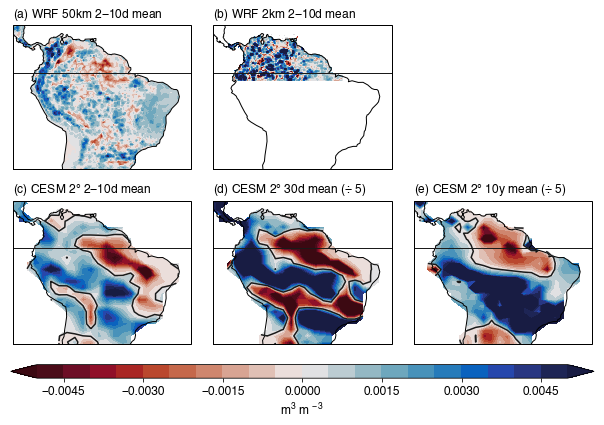

In [94]:
fontsize=12

fig = mp.figure(figsize=(8.5,4.75))

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(231, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(232, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(234, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(235, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(236, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-0.005,0.0051,0.0005)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], soilh2o_wtdmean_50km, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour2 = ax2.contourf(xlong_2km[0,:], xlat_2km[:,0], \
                        soilh2o_diffs_convolved, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax3.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax4.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year/5., \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax5.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(a) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(b) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='(c) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(d) CESM 2$\degree$ 30d mean ($\div$ 5)', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(e) CESM 2$\degree$ 10y mean ($\div$ 5)', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

fig.tight_layout(h_pad=3)

axlpos = ax3.get_position()
axrpos = ax5.get_position()

cbar_ax = fig.add_axes([axlpos.x0,axlpos.y0-0.1,axrpos.x1-axlpos.x0,0.04])
cbar = fig.colorbar(contour1, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('m$^3$ m$^{\,-3}$', fontsize=fontsize)

#fig.savefig('../figures/REVISION_soil_moisture_maps.png', dpi=600, bbox_inches='tight', transparent=True)


# combine into one large figure

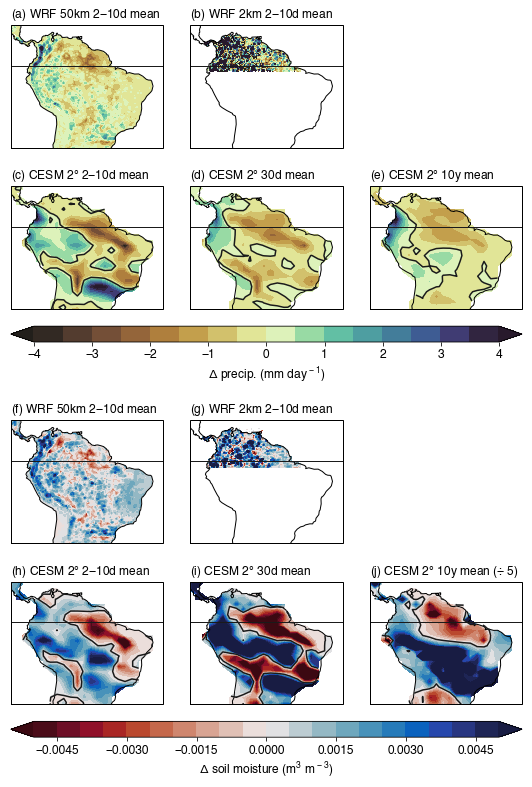

In [95]:
fontsize=12

fig = mp.figure(figsize=(7.5,11.))

gs = matplotlib.gridspec.GridSpec(6, 3,
                       width_ratios=[2,2,2],
                       height_ratios=[2,2,.75,2,2,.75]
                       )

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(gs[0], projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(gs[1], projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(gs[3], projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(gs[4], projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(gs[5], projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-4,4.1,0.5)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        #raintot_diffs_convolved*24., \
                        raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape))*24., \
                        levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax3.contour(lon_subset, lat_subset_open, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax4.contour(lon_subset, lat_subset_open, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax5.contour(lon_subset, lat_subset_open, PRECT_diffs_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(a) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(b) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='(c) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(d) CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(e) CESM 2$\degree$ 10y mean', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

ax3_top = ax3
ax5_top = ax5
contour1_top = contour1



map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(gs[9], projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(gs[10], projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(gs[12], projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(gs[13], projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(gs[14], projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-0.005,0.0051,0.0005)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], soilh2o_wtdmean_50km, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour2 = ax2.contourf(xlong_2km[0,:], xlat_2km[:,0], \
                        soilh2o_diffs_convolved, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax3.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax4.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year/5., \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax5.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(f) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(g) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='(h) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(i) CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(j) CESM 2$\degree$ 10y mean ($\div$ 5)', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

fig.tight_layout(h_pad=2, w_pad=2)

# top plots
axlpos = ax3_top.get_position()
axrpos = ax5_top.get_position()

cbar_ax = fig.add_axes([axlpos.x0,axlpos.y0-0.03,axrpos.x1-axlpos.x0,0.02])
cbar = fig.colorbar(contour1_top, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ precip. (mm day$^{\,-1}$)', fontsize=fontsize)


# bottom plots
axlpos = ax3.get_position()
axrpos = ax5.get_position()

cbar_ax = fig.add_axes([axlpos.x0,axlpos.y0-0.03,axrpos.x1-axlpos.x0,0.02])
cbar = fig.colorbar(contour1, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ soil moisture (m$^3$ m$^{\,-3}$)', fontsize=fontsize)


#fig.savefig('../figures/REVISION_cesm_and_wrf_precip_and_smois_above_200cm_maps.png', dpi=600, bbox_inches='tight', transparent=True)

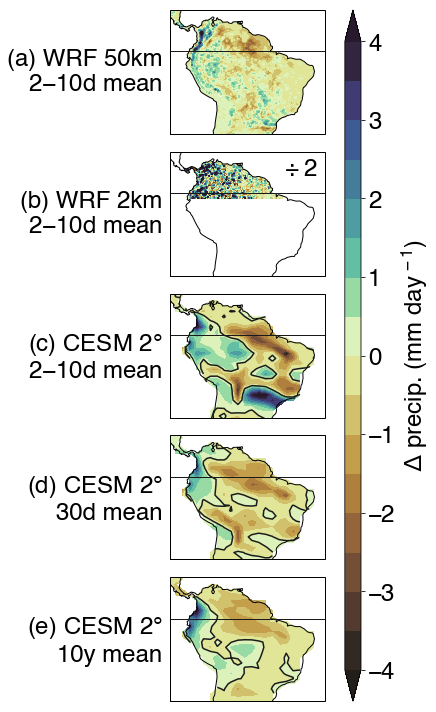

In [107]:
fontsize=24

fig = mp.figure(figsize=(3,10))

# gs = matplotlib.gridspec.GridSpec(6, 3,
#                        width_ratios=[2,2,2],
#                        height_ratios=[2,2,.75,2,2,.75]
#                        )

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(511, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(512, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(513, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(514, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(515, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-4,4.1,0.5)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        #raintot_diffs_convolved*24., \
                        raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape))*24./2, \
                        levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax3.contour(lon_subset, lat_subset_open, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax4.contour(lon_subset, lat_subset_open, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax5.contour(lon_subset, lat_subset_open, PRECT_diffs_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

fig.tight_layout()

ax1.text(s='(a) WRF 50km\n2$-$10d mean', x=-.05, y=0.5, transform=ax1.transAxes, fontsize=fontsize, ha='right', va='center')
ax2.text(s='(b) WRF 2km\n2$-$10d mean', x=-.05, y=0.5, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='center')
ax3.text(s='(c) CESM 2$\degree$\n2$-$10d mean', x=-.05, y=0.5, transform=ax3.transAxes, fontsize=fontsize, ha='right', va='center')
ax4.text(s='(d) CESM 2$\degree$\n30d mean', x=-.05, y=0.5, transform=ax4.transAxes, fontsize=fontsize, ha='right', va='center')
ax5.text(s='(e) CESM 2$\degree$\n10y mean', x=-.05, y=0.5, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='center')
ax2.text(s='$\div$ 2', x=0.96, y=0.95, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='top')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

ax3_top = ax3
ax5_top = ax5
contour1_top = contour1

# top plots
#axlpos = ax3_top.get_position()
#axrpos = ax5_top.get_position()
axtpos = ax1.get_position()
axbpos = ax5.get_position()

cbar_ax = fig.add_axes([axbpos.x1,axbpos.y0,0.075,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1_top, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ precip. (mm day$^{\,-1}$)', fontsize=fontsize)

fig.savefig('../figures/POSTER_precip_maps.pdf', bbox_inches='tight', transparent=True)

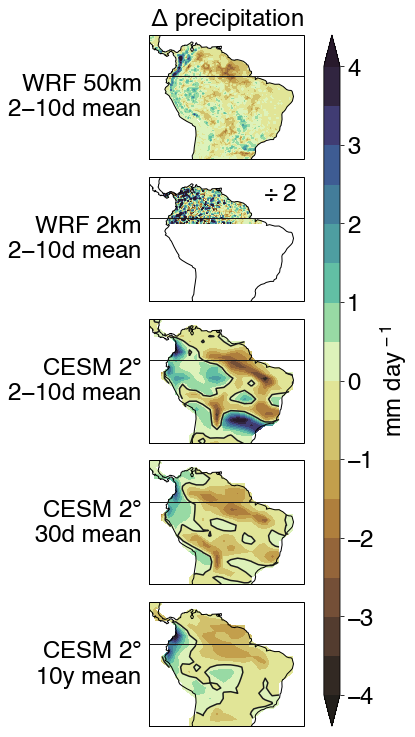

In [125]:
fontsize=24

fig = mp.figure(figsize=(3,10))

# gs = matplotlib.gridspec.GridSpec(6, 3,
#                        width_ratios=[2,2,2],
#                        height_ratios=[2,2,.75,2,2,.75]
#                        )

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(511, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(512, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(513, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(514, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(515, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-4,4.1,0.5)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        #raintot_diffs_convolved*24., \
                        raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape))*24./2, \
                        levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax3.contour(lon_subset, lat_subset_open, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax4.contour(lon_subset, lat_subset_open, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax5.contour(lon_subset, lat_subset_open, PRECT_diffs_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

fig.tight_layout()

ax1.text(s='WRF 50km\n2$-$10d mean', x=-.05, y=0.5, transform=ax1.transAxes, fontsize=fontsize, ha='right', va='center')
ax2.text(s='WRF 2km\n2$-$10d mean', x=-.05, y=0.5, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='center')
ax3.text(s='CESM 2$\degree$\n2$-$10d mean', x=-.05, y=0.5, transform=ax3.transAxes, fontsize=fontsize, ha='right', va='center')
ax4.text(s='CESM 2$\degree$\n30d mean', x=-.05, y=0.5, transform=ax4.transAxes, fontsize=fontsize, ha='right', va='center')
ax5.text(s='CESM 2$\degree$\n10y mean', x=-.05, y=0.5, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='center')
ax2.text(s='$\div$ 2', x=0.96, y=0.95, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='top')
ax1.text(s='$\Delta$ precipitation', x=0.5, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='center', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

ax3_top = ax3
ax5_top = ax5
contour1_top = contour1

# top plots
#axlpos = ax3_top.get_position()
#axrpos = ax5_top.get_position()
axtpos = ax1.get_position()
axbpos = ax5.get_position()

cbar_ax = fig.add_axes([axbpos.x1,axbpos.y0,0.075,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1_top, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

fig.savefig('../figures/POSTER_precip_maps_noletters.pdf', bbox_inches='tight', transparent=True)

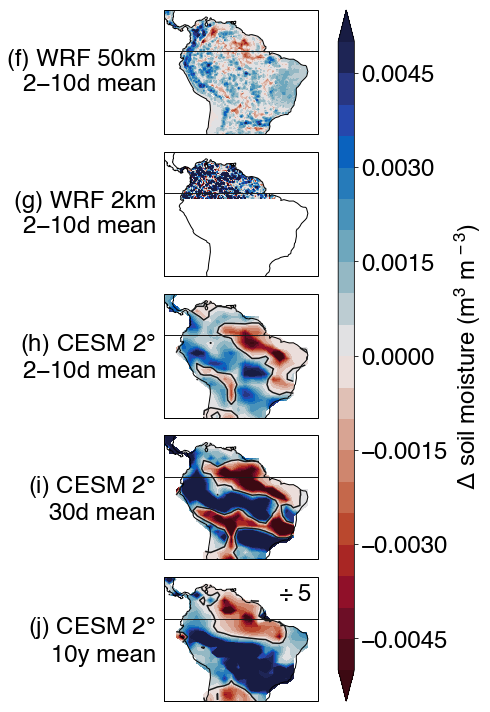

In [118]:
fontsize=24

fig = mp.figure(figsize=(3,10))

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(511, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(512, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(513, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(514, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(515, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-0.005,0.0051,0.0005)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], soilh2o_wtdmean_50km, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        soilh2o_2km_interpolated.reshape(xlong.shape), \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax3.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax4.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year/5., \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax5.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

fig.tight_layout()

ax1.text(s='(f) WRF 50km\n2$-$10d mean', x=-.05, y=0.5, transform=ax1.transAxes, fontsize=fontsize, ha='right', va='center')
ax2.text(s='(g) WRF 2km\n2$-$10d mean', x=-.05, y=0.5, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='center')
ax3.text(s='(h) CESM 2$\degree$\n2$-$10d mean', x=-.05, y=0.5, transform=ax3.transAxes, fontsize=fontsize, ha='right', va='center')
ax4.text(s='(i) CESM 2$\degree$\n30d mean', x=-.05, y=0.5, transform=ax4.transAxes, fontsize=fontsize, ha='right', va='center')
ax5.text(s='(j) CESM 2$\degree$\n10y mean', x=-.05, y=0.5, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='center')
#ax2.text(s='$\div$ 2', x=0.96, y=0.95, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='top')
ax5.text(s='$\div$ 5', x=0.96, y=0.95, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='top')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

# bottom plots
axtpos = ax1.get_position()
axbpos = ax5.get_position()

cbar_ax = fig.add_axes([axbpos.x1,axbpos.y0,0.075,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ soil moisture (m$^3$ m$^{\,-3}$)', fontsize=fontsize)

fig.savefig('../figures/POSTER_soil_moisture_maps.pdf', bbox_inches='tight', transparent=True)

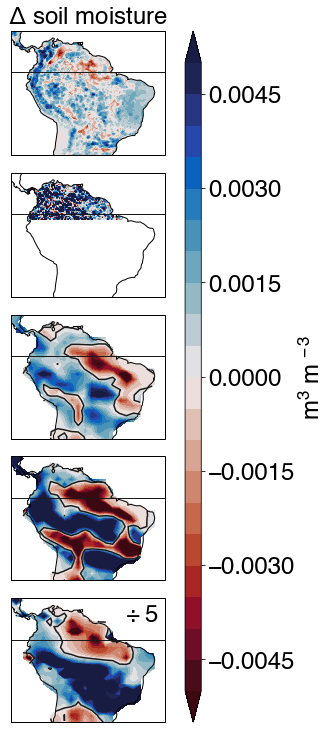

In [127]:
fontsize=24

fig = mp.figure(figsize=(3,10))

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(511, projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(512, projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(513, projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(514, projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(515, projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-0.005,0.0051,0.0005)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], soilh2o_wtdmean_50km, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        soilh2o_2km_interpolated.reshape(xlong.shape), \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax3.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax4.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year/5., \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax5.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

fig.tight_layout()

# ax1.text(s='(f) WRF 50km\n2$-$10d mean', x=-.05, y=0.5, transform=ax1.transAxes, fontsize=fontsize, ha='right', va='center')
# ax2.text(s='(g) WRF 2km\n2$-$10d mean', x=-.05, y=0.5, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='center')
# ax3.text(s='(h) CESM 2$\degree$\n2$-$10d mean', x=-.05, y=0.5, transform=ax3.transAxes, fontsize=fontsize, ha='right', va='center')
# ax4.text(s='(i) CESM 2$\degree$\n30d mean', x=-.05, y=0.5, transform=ax4.transAxes, fontsize=fontsize, ha='right', va='center')
# ax5.text(s='(j) CESM 2$\degree$\n10y mean', x=-.05, y=0.5, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='center')
#ax2.text(s='$\div$ 2', x=0.96, y=0.95, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='top')
ax5.text(s='$\div$ 5', x=0.96, y=0.95, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='top')
ax1.text(s='$\Delta$ soil moisture', x=0.5, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='center', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

# bottom plots
axtpos = ax1.get_position()
axbpos = ax5.get_position()

cbar_ax = fig.add_axes([axbpos.x1,axbpos.y0,0.075,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('m$^3$ m$^{\,-3}$', fontsize=fontsize)

fig.savefig('../figures/POSTER_soil_moisture_maps_noletters.pdf', bbox_inches='tight', transparent=True)

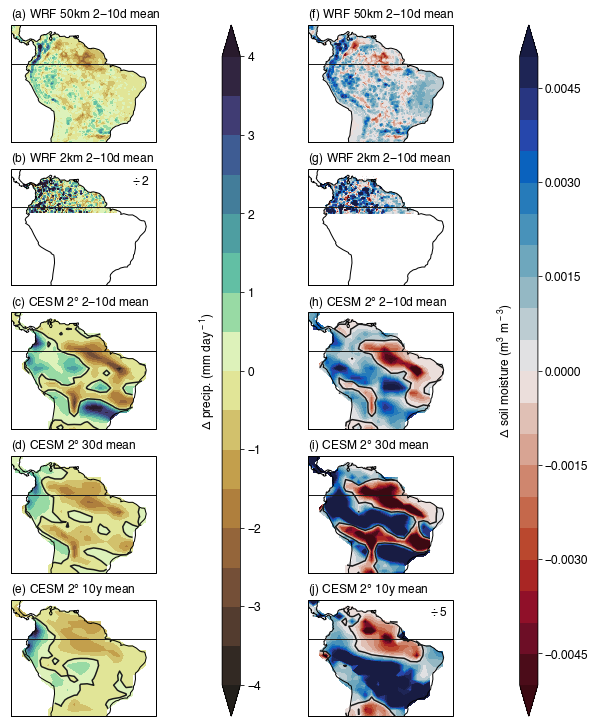

In [99]:
fontsize=12

fig = mp.figure(figsize=(8.5,10))

# gs = matplotlib.gridspec.GridSpec(6, 3,
#                        width_ratios=[2,2,2],
#                        height_ratios=[2,2,.75,2,2,.75]
#                        )

gs = matplotlib.gridspec.GridSpec(5, 4,
                       width_ratios=[1,0.333,1,0.333],
                       height_ratios=[1,1,1,1,1]
                       )

map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(gs[0], projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(gs[4], projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(gs[8], projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(gs[12], projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(gs[16], projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-4,4.1,0.5)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], raintot_diffs_time_mean_landmask*24., levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour2 = ax2.contourf(xlong[0,:], xlat[:,0], \
                        #raintot_diffs_convolved*24., \
                        raintot_diffs_2km_time_mean_landmask_interpolated.reshape((xlong.shape))*24./2, \
                        levels=levels1, cmap=turbid_deep_cmap, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, PRECT_diffs_10day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax3.contour(lon_subset, lat_subset_open, PRECT_diffs_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, PRECT_diffs_30day*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax4.contour(lon_subset, lat_subset_open, PRECT_diffs_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, PRECT_diffs_10year*86400.*1000, levels=levels1, cmap=turbid_deep_cmap, extend='both')
ax5.contour(lon_subset, lat_subset_open, PRECT_diffs_10year, levels=[0], colors='0.1')

# for c in contour1.collections:
#     c.set_rasterized(True)
# for c in contour2.collections:
#     c.set_rasterized(True)
# for c in contour3.collections:
#     c.set_rasterized(True)
# for c in contour4.collections:
#     c.set_rasterized(True)
# for c in contour5.collections:
#     c.set_rasterized(True)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(a) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(b) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='$\div$ 2', x=0.96, y=0.95, transform=ax2.transAxes, fontsize=fontsize, ha='right', va='top')
ax3.text(s='(c) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(d) CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(e) CESM 2$\degree$ 10y mean', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

ax3_top = ax3
ax5_top = ax5
ax1_top = ax1
contour1_top = contour1



map_proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(gs[2], projection=map_proj)
ax1.set_extent([273,329,-30,15], crs=map_proj)

ax2 = fig.add_subplot(gs[6], projection=map_proj)
ax2.set_extent([273,329,-30,15], crs=map_proj)

ax3 = fig.add_subplot(gs[10], projection=map_proj)
ax3.set_extent([273,329,-30,15], crs=map_proj)

ax4 = fig.add_subplot(gs[14], projection=map_proj)
ax4.set_extent([273,329,-30,15], crs=map_proj)

ax5 = fig.add_subplot(gs[18], projection=map_proj)
ax5.set_extent([273,329,-30,15], crs=map_proj)

levels1 = numpy.arange(-0.005,0.0051,0.0005)

contour1 = ax1.contourf(xlong[0,:], xlat[:,0], soilh2o_wtdmean_50km, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour2 = ax2.contourf(xlong_2km[0,:], xlat_2km[:,0], \
                        soilh2o_diffs_convolved, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')

contour3 = ax3.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax3.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10day, levels=[0], colors='0.1')

contour4 = ax4.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax4.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_30day, levels=[0], colors='0.1')

contour5 = ax5.contourf(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year/5., \
                        levels=levels1, \
                        cmap=cmocean.cm.balance_r, extend='both')
ax5.contour(lon_subset, lat_subset_open, SOILLIQ_wtdmean_10year, levels=[0], colors='0.1')

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

ax1.text(s='(f) WRF 50km 2$-$10d mean', x=0, y=1.02, transform=ax1.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax2.text(s='(g) WRF 2km 2$-$10d mean', x=0, y=1.02, transform=ax2.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax3.text(s='(h) CESM 2$\degree$ 2$-$10d mean', x=0, y=1.02, transform=ax3.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax4.text(s='(i) CESM 2$\degree$ 30d mean', x=0, y=1.02, transform=ax4.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='(j) CESM 2$\degree$ 10y mean', x=0, y=1.02, transform=ax5.transAxes, fontsize=fontsize, ha='left', va='bottom')
ax5.text(s='$\div$ 5', x=0.96, y=0.95, transform=ax5.transAxes, fontsize=fontsize, ha='right', va='top')

ax1.axhline(0, lw='1', color='0.1', ls='-')
ax2.axhline(0, lw='1', color='0.1', ls='-')
ax3.axhline(0, lw='1', color='0.1', ls='-')
ax4.axhline(0, lw='1', color='0.1', ls='-')
ax5.axhline(0, lw='1', color='0.1', ls='-')

fig.tight_layout(h_pad=2, w_pad=2)

# top plots
axtpos = ax1_top.get_position()
axbpos = ax5_top.get_position()

cbar_ax = fig.add_axes([axbpos.x1+0.05,axbpos.y0,0.03,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1_top, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ precip. (mm day$^{\,-1}$)', fontsize=fontsize)
cbar_ax.yaxis.set_label_position('left')

# bottom plots
axtpos = ax1.get_position()
axbpos = ax5.get_position()

cbar_ax = fig.add_axes([axbpos.x1+0.05,axbpos.y0,0.03,axtpos.y1-axbpos.y0])
cbar = fig.colorbar(contour1, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\Delta$ soil moisture (m$^3$ m$^{\,-3}$)', fontsize=fontsize)
cbar_ax.yaxis.set_label_position('left')

#fig.savefig('../figures/SI_fig04.png', dpi=300, bbox_inches='tight', transparent=True)